In [1]:
import os
import numpy as np
import json
import time
from sklearn.metrics import pairwise

In [2]:
def scale_transform_normalize(coords):
    """
    Parameters:
    coords (ndarray): array of (x,y,c) coordinates

    Returns:
    ndarray: coords scaled to 1x1 with center at (0,0)
    ndarray: confidence scores of each joint
    """
    coords, scores = coords[:,:,:-1], coords[:,:,-1]
    diff = coords.max(axis=1) - coords.min(axis=1)
    diff_max = np.max(diff, axis=0)
    mean = coords.mean(axis=1).reshape(coords.shape[0],1,coords.shape[-1])
    out = (coords - mean) / diff_max
    
    return out, scores

In [3]:

json_dir='/content/drive/MyDrive/posedetection/selected_frame_5/'
final_data=np.array([])
filenames=[]
for filename in sorted(os.listdir(json_dir)):
  filenames.append([filename][0][:-15])
  print(filename)

  f = open(json_dir+filename,)
  data = json.load(f)
  keypoints=list(data.items())[1][1][0]['pose_keypoints_2d']
  image_keypoints=[]
  
  
  for keys in range(0,len(keypoints),3):
    image_keypoints.append(np.array([keypoints[keys],keypoints[keys+1],keypoints[keys+2]]))
  final_data=np.append(final_data,image_keypoints)


  f.close()


1_startingpose_keypoints.json
2_movingforward_keypoints.json
3_completesquat_keypoints.json
4_movingbackward_keypoints.json
5_endingpose_keypoints.json


In [ ]:
poses=final_data.reshape(5,18,3)
poses, scores = scale_transform_normalize(poses)
poses /= np.linalg.norm(poses, axis=2)[:, :, np.newaxis]


poses = poses.reshape((poses.shape[0], -1))

In [ ]:
start_pose=poses[0].reshape(1,-1)
quarter_pose=poses[1].reshape(1,-1)
mid_pose=poses[4].reshape(1,-1)
threefourth_pose=poses[2].reshape(1,-1)
end_pose=poses[3].reshape(1,-1)

user_json_dir='/content/drive/MyDrive/posedetection/json_video/'
start=time.time()
video_frames=[]
prev_pose=-1
rep_counter=0
progress_counter=[]
for video_frame in sorted(os.listdir(user_json_dir)):
  
  res_data=np.array([])
  video_frames.append([video_frame][0][:-15])
  f = open(user_json_dir+video_frame,)
  data = json.load(f)
  keypoints=list(data.items())[1][1][0]['pose_keypoints_2d']
  image_keypoints=[]
  
  for keys in range(0,len(keypoints),3):
    image_keypoints.append(np.array([keypoints[keys],keypoints[keys+1],keypoints[keys+2]]))
  res_data=np.append(res_data,image_keypoints)
  f.close()
  
  user_pose=res_data.reshape(1,18,3)
  user_pose, scores = scale_transform_normalize(user_pose)
  user_pose /= np.linalg.norm(user_pose, axis=2)[:, :, np.newaxis]
  user_pose = user_pose.reshape((user_pose.shape[0], -1))

  if pairwise.cosine_similarity(user_pose,start_pose)[0]>=0.99 and (prev_pose==0 or prev_pose==-1):
    progress_counter.append(0)
    prev_pose=0
  elif pairwise.cosine_similarity(user_pose,quarter_pose)[0]>=0.99 and prev_pose==0:
    progress_counter.append(0)
    prev_pose=1
  elif pairwise.cosine_similarity(user_pose,quarter_pose)[0]>=0.99 and prev_pose==1:
    progress_counter.append(0.25)
    prev_pose=1
  elif pairwise.cosine_similarity(user_pose,mid_pose)[0]>=0.99 and prev_pose==1:
    progress_counter.append(0.25)
    prev_pose=2
    rep_counter+=1
  elif pairwise.cosine_similarity(user_pose,mid_pose)[0]>=0.99 and prev_pose==2:
    progress_counter.append(0.50)
    prev_pose=2
  elif pairwise.cosine_similarity(user_pose,threefourth_pose)[0]>=0.99 and prev_pose==2:
    progress_counter.append(0.50)
    prev_pose=3
  elif pairwise.cosine_similarity(user_pose,threefourth_pose)[0]>=0.99 and prev_pose==3:
    progress_counter.append(0.75)
    prev_pose=3
  elif pairwise.cosine_similarity(user_pose,end_pose)[0]>=0.99 and prev_pose==3:
    progress_counter.append(0.75)
    prev_pose=4
  elif pairwise.cosine_similarity(user_pose,end_pose)[0]>=0.99 and prev_pose==4:
    progress_counter.append(1)
    prev_pose=4
  

  
  



print(time.time()-start)



0.5686023235321045


In [ ]:
rep_counter

1

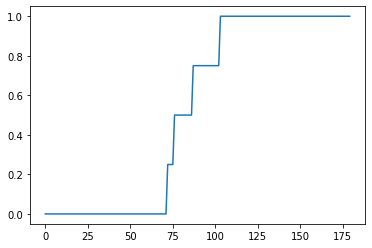

In [ ]:
import matplotlib.pyplot as plt
plt.plot(progress_counter)
